# Evaluación de Modelos para Detección de Fraude

Este notebook evalúa en profundidad los modelos entrenados para la detección de fraude en transacciones de tarjetas de crédito.

## Contenido

1. Carga de datos y modelos
2. Evaluación detallada de modelos
3. Comparación de modelos
4. Análisis de matrices de confusión
5. Análisis de curvas ROC y Precision-Recall
6. Análisis de calibración de modelos
7. Análisis de importancia de características
8. Análisis de valores SHAP
9. Análisis del impacto del umbral de clasificación
10. Análisis de costo-beneficio
11. Generación de informe de evaluación

In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import time
import glob
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score, roc_curve,
    fbeta_score, matthews_corrcoef, cohen_kappa_score
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
import shap

# Configurar visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

# Añadir directorio raíz al path para importar módulos personalizados
sys.path.append('..')

# Importar funciones personalizadas
from src.config import (
    RANDOM_STATE, MODELS_DIR, REPORTS_DIR, FIGURES_DIR,
    X_TRAIN_FILE, X_TEST_FILE, Y_TRAIN_FILE, Y_TEST_FILE
)
from src.data_prep import load_processed_data
from src.model_training import load_model
from src.evaluate import (
    load_models, evaluate_model_detailed, evaluate_all_models,
    compare_models_detailed, plot_all_confusion_matrices,
    plot_all_roc_curves, plot_all_precision_recall_curves,
    plot_calibration_curves, analyze_feature_importance,
    analyze_shap_values, analyze_threshold_impact,
    analyze_cost_benefit, generate_evaluation_report,
    evaluation_pipeline
)
from src.utils import timer_decorator, save_figure

## 1. Carga de datos y modelos

In [3]:
# Cargar datos procesados
print("Cargando datos procesados...")
X_train, X_test, y_train, y_test, feature_names = load_processed_data()

print(f"\nDimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")

Cargando datos procesados...
Cargando datos procesados...
Datos cargados:
X_train: (453204, 42)
X_test: (56746, 42)
y_train: (453204,)
y_test: (56746,)
Función load_processed_data ejecutada en 4.34 segundos

Dimensiones de X_train: (453204, 42)
Dimensiones de X_test: (56746, 42)
Dimensiones de y_train: (453204,)
Dimensiones de y_test: (56746,)


In [ ]:
# Cargar modelos entrenados
print("Cargando modelos entrenados...")
# Opción 1: Usar la función mejorada
models = load_models(MODELS_DIR)

print(f"\nModelos cargados: {len(models)}")
for name in models.keys():
    print(f"  - {name}")

Cargando modelos entrenados...
Cargando modelos desde c:\Projects\Credit_fraud\models...
  ERROR al cargar c:\Projects\Credit_fraud\models\best_metrics.pkl: name 'pickle' is not defined
  ERROR al cargar c:\Projects\Credit_fraud\models\best_params.pkl: name 'pickle' is not defined
  ERROR al cargar c:\Projects\Credit_fraud\models\gradient_boosting.pkl: name 'pickle' is not defined
  ERROR al cargar c:\Projects\Credit_fraud\models\lightgbm.pkl: name 'pickle' is not defined
  ERROR al cargar c:\Projects\Credit_fraud\models\logistic_regression.pkl: name 'pickle' is not defined
  ERROR al cargar c:\Projects\Credit_fraud\models\random_forest.pkl: name 'pickle' is not defined
  ERROR al cargar c:\Projects\Credit_fraud\models\xgboost.pkl: name 'pickle' is not defined
Total de modelos cargados: 0
Función load_models ejecutada en 0.00 segundos

Modelos cargados: 0


## 2. Evaluación detallada de modelos

In [4]:
# Evaluar todos los modelos
print("Evaluando todos los modelos...")
all_metrics, comparison_df = evaluate_all_models(models, X_test, y_test)

# Mostrar comparación
comparison_df

Evaluando todos los modelos...
Evaluando todos los modelos...
Evaluando modelo: best_metrics


AttributeError: 'dict' object has no attribute 'predict'

In [5]:
# Identificar el mejor modelo según F1
best_model_name = comparison_df.iloc[0]['Modelo']
best_model = models[best_model_name]
best_metrics = all_metrics[best_model_name]

print(f"Mejor modelo según F1: {best_model_name}")
print(f"F1 Score: {best_metrics['f1']:.4f}")
print(f"Precision: {best_metrics['precision']:.4f}")
print(f"Recall: {best_metrics['recall']:.4f}")
print(f"F2 Score: {best_metrics['f2']:.4f}")
print(f"MCC: {best_metrics['mcc']:.4f}")
print(f"Kappa: {best_metrics['kappa']:.4f}")
if 'roc_auc' in best_metrics:
    print(f"AUC: {best_metrics['roc_auc']:.4f}")
if 'avg_precision' in best_metrics:
    print(f"AP: {best_metrics['avg_precision']:.4f}")

Mejor modelo según F1: random_forest
F1 Score: 0.8304
Precision: 0.9342
Recall: 0.7474
F2 Score: 0.7785
MCC: 0.8353
Kappa: 0.8302
AUC: 0.9633
AP: 0.8221


## 3. Comparación de modelos

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\model_comparison_heatmap.png


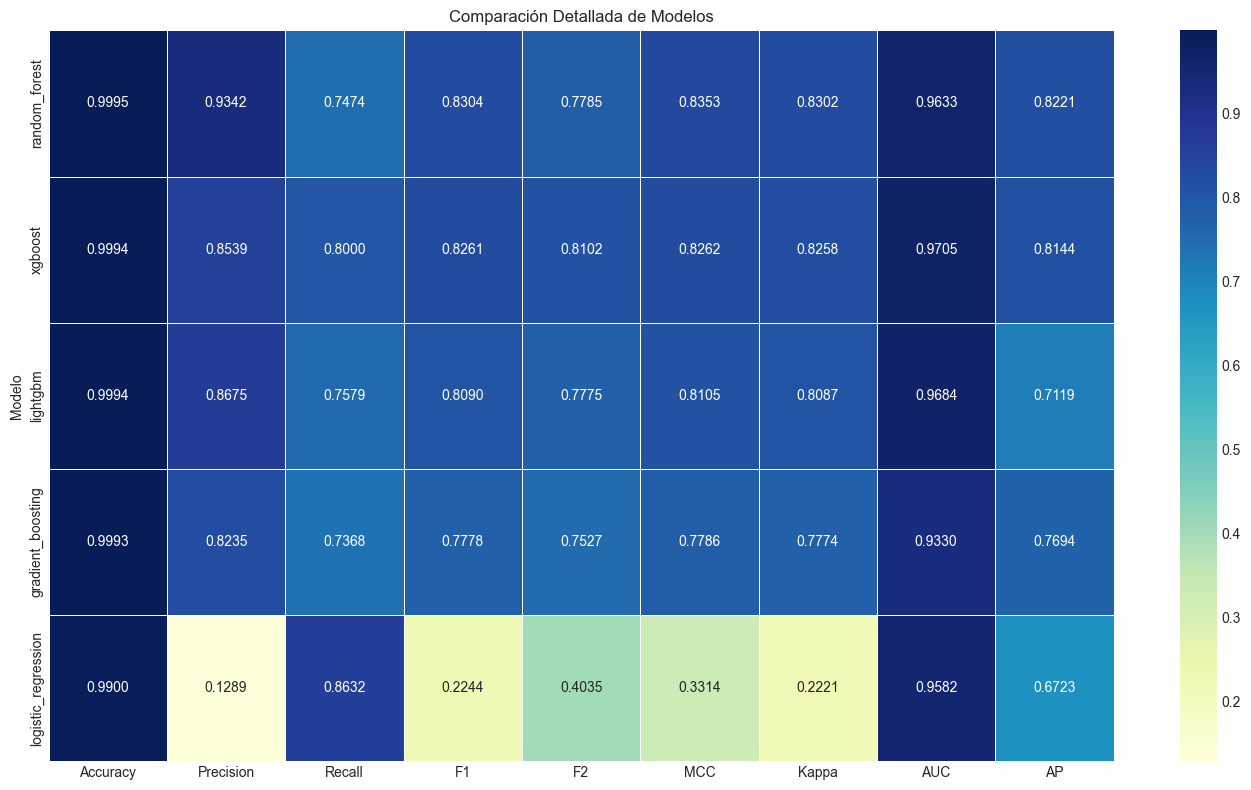

In [6]:
# Visualizar comparación de modelos como heatmap
plt.figure(figsize=(14, 8))
metric_cols = [col for col in comparison_df.columns if col != 'Modelo']
sns.heatmap(comparison_df.set_index('Modelo')[metric_cols], annot=True, 
            cmap='YlGnBu', fmt='.4f', linewidths=.5)
plt.title('Comparación Detallada de Modelos')
plt.tight_layout()
save_figure('model_comparison_heatmap.png')
plt.show()

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\model_comparison_bar.png


<Figure size 1400x800 with 0 Axes>

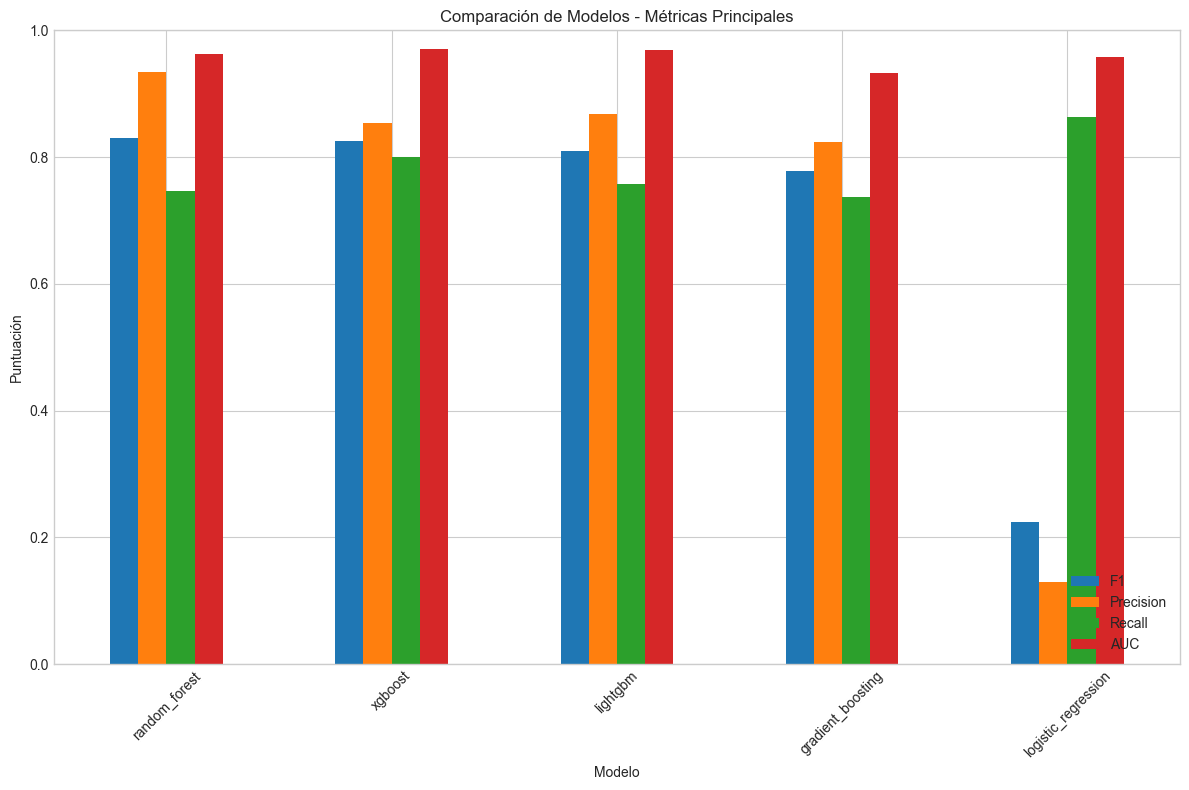

In [7]:
# Visualizar comparación de modelos como gráfico de barras
plt.figure(figsize=(14, 8))
comparison_df.set_index('Modelo')[['F1', 'Precision', 'Recall', 'AUC']].plot(kind='bar')
plt.title('Comparación de Modelos - Métricas Principales')
plt.ylabel('Puntuación')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
save_figure('model_comparison_bar.png')
plt.show()

## 4. Análisis de matrices de confusión

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\all_confusion_matrices.png


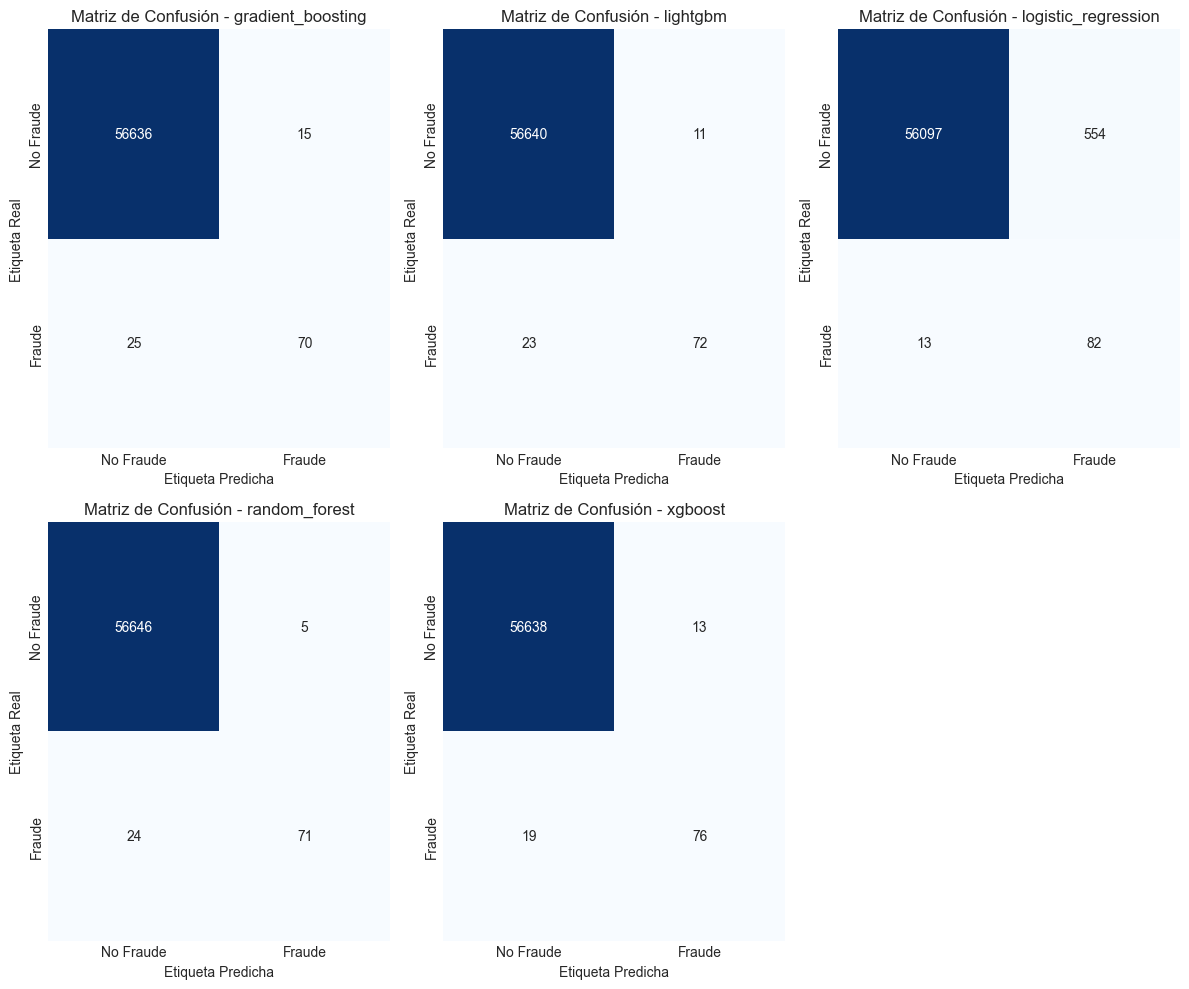

In [8]:
# Visualizar matrices de confusión para todos los modelos
plot_all_confusion_matrices(all_metrics)

In [9]:
# Analizar matriz de confusión del mejor modelo en detalle
cm = best_metrics['confusion_matrix']
tn, fp, fn, tp = cm.ravel()

print(f"Matriz de confusión para {best_model_name}:")
print(f"  Verdaderos Negativos (TN): {tn}")
print(f"  Falsos Positivos (FP): {fp}")
print(f"  Falsos Negativos (FN): {fn}")
print(f"  Verdaderos Positivos (TP): {tp}")

# Calcular métricas adicionales
specificity = tn / (tn + fp)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nMétricas adicionales:")
print(f"  Especificidad: {specificity:.4f}")
print(f"  Tasa de Falsos Positivos: {false_positive_rate:.4f}")
print(f"  Tasa de Falsos Negativos: {false_negative_rate:.4f}")
print(f"  Precisión: {precision:.4f}")
print(f"  Recall: {recall:.4f}")

Matriz de confusión para random_forest:
  Verdaderos Negativos (TN): 56646
  Falsos Positivos (FP): 5
  Falsos Negativos (FN): 24
  Verdaderos Positivos (TP): 71

Métricas adicionales:
  Especificidad: 0.9999
  Tasa de Falsos Positivos: 0.0001
  Tasa de Falsos Negativos: 0.2526
  Precisión: 0.9342
  Recall: 0.7474


## 5. Análisis de curvas ROC y Precision-Recall

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\all_roc_curves.png


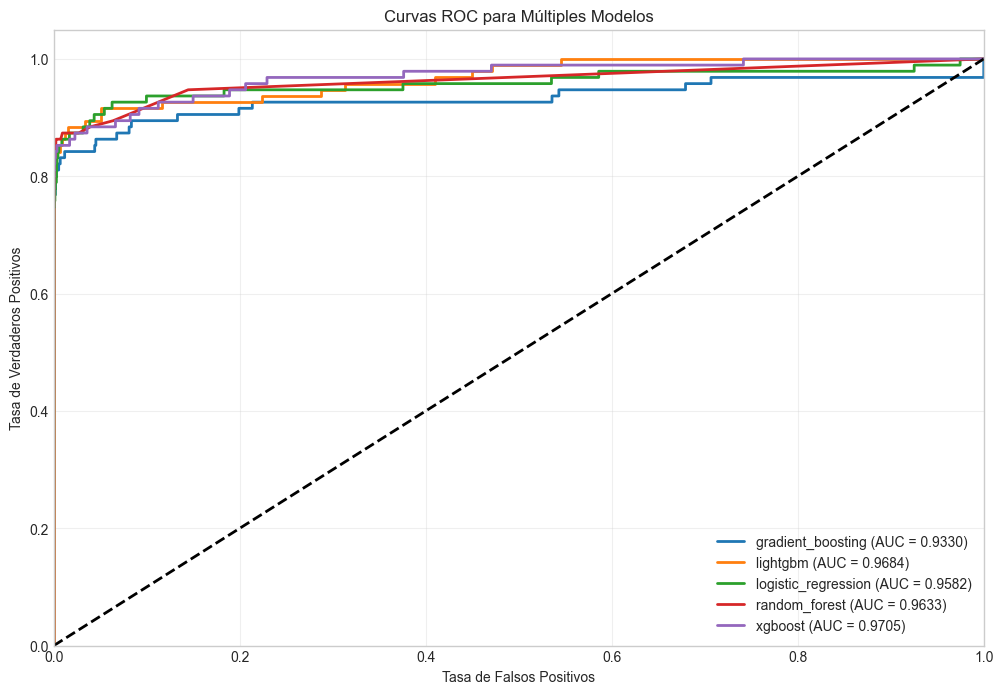

Función plot_all_roc_curves ejecutada en 0.55 segundos


In [10]:
# Visualizar curvas ROC para todos los modelos
plot_all_roc_curves(all_metrics, y_test=y_test)

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\all_precision_recall_curves.png


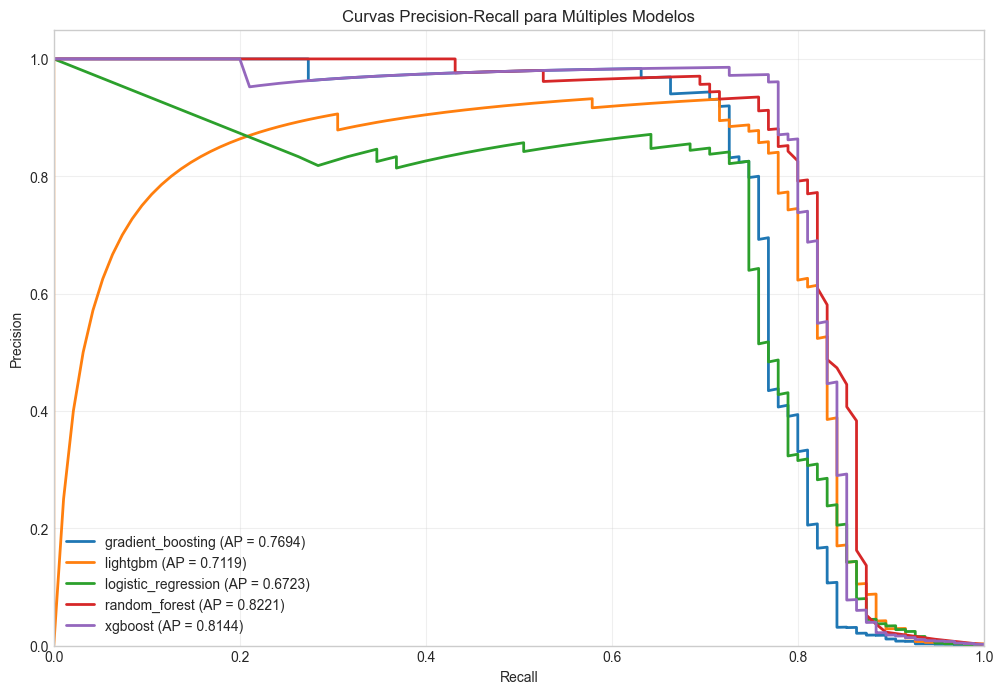

Función plot_all_precision_recall_curves ejecutada en 0.52 segundos


In [11]:
# Visualizar curvas Precision-Recall para todos los modelos
plot_all_precision_recall_curves(all_metrics, y_test=y_test)

## 6. Análisis de calibración de modelos

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\calibration_curves.png


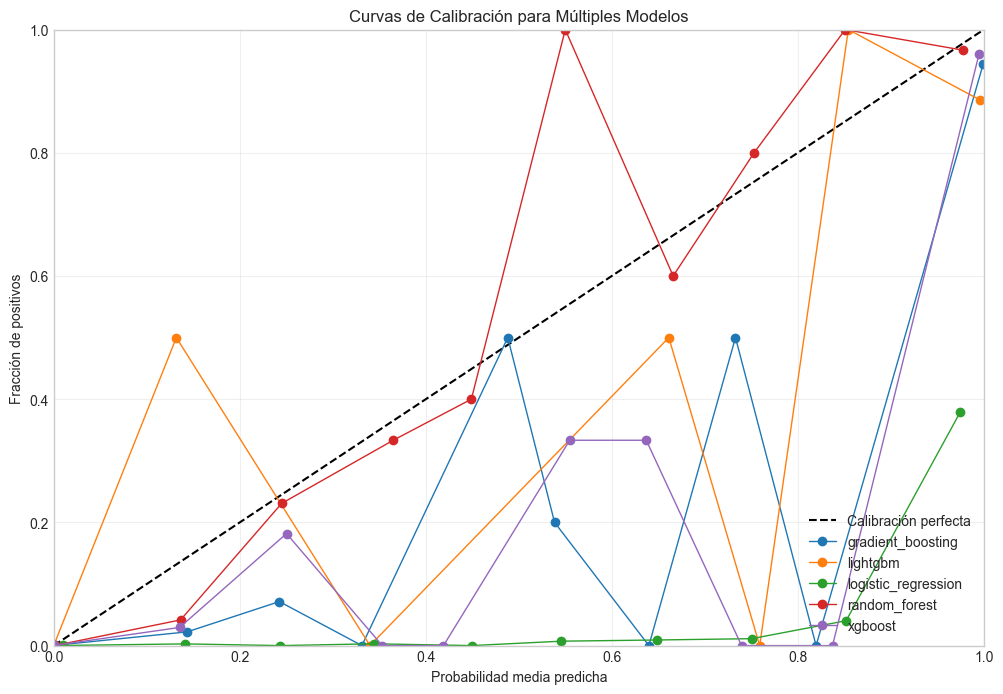

Función plot_calibration_curves ejecutada en 0.49 segundos


In [12]:
# Visualizar curvas de calibración para todos los modelos
plot_calibration_curves(all_metrics, y_test=y_test)

## 7. Análisis de importancia de características

Analizando importancia de características para random_forest...
Analizando importancia de características...
Importancia de características guardada en g:\Proyectos\credit_fraud_detection\reports\feature_importance.csv
Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\feature_importance.png


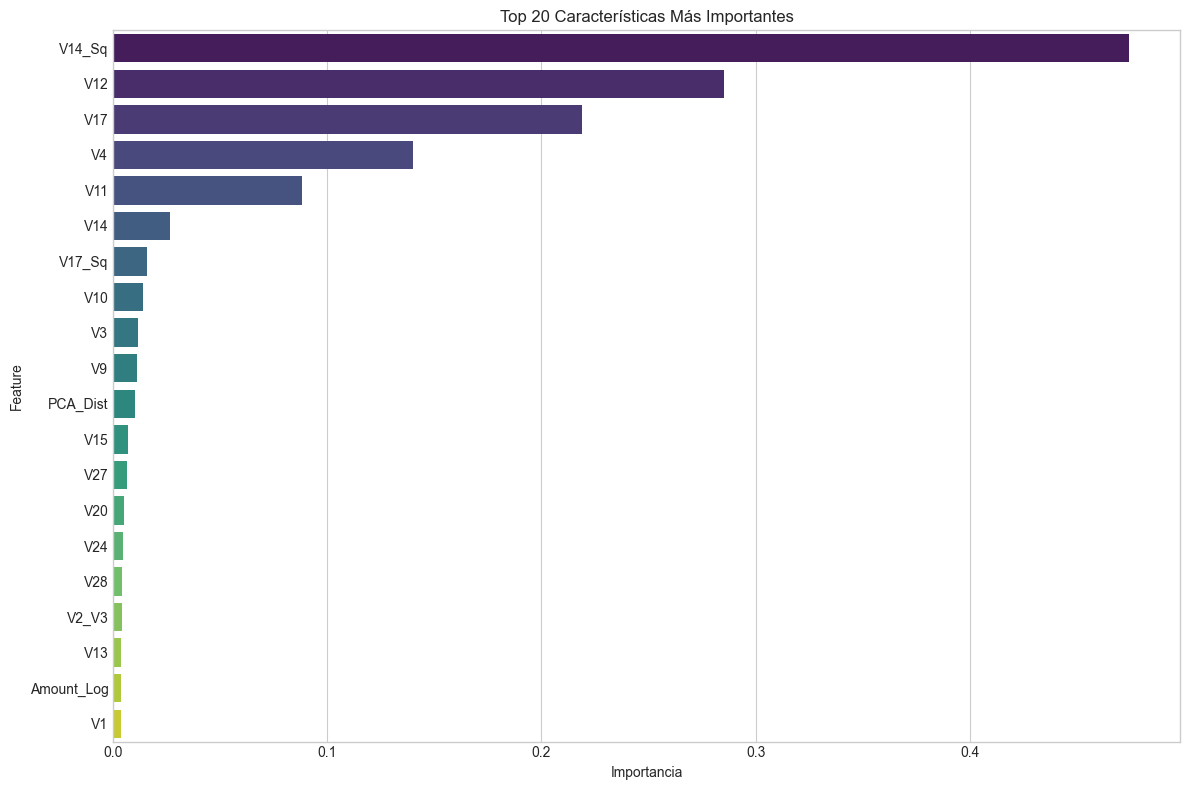

Función analyze_feature_importance ejecutada en 71.27 segundos


,Feature,Importance,Std
18,V14_Sq,0.474458,0.040927
32,V12,0.285456,0.027432
31,V17,0.219042,0.011941
6,V4,0.139893,0.034321
19,V11,0.088002,0.023021
12,V14,0.026483,0.010547
27,V17_Sq,0.015996,0.006172
24,V10,0.014036,0.007348
11,V3,0.011811,0.008874
34,V9,0.010930,0.004808


In [13]:
# Analizar importancia de características para el mejor modelo
print(f"Analizando importancia de características para {best_model_name}...")
importance_df = analyze_feature_importance(best_model, X_test, y_test, feature_names)

# Mostrar top 20 características
importance_df.head(20)

## 8. Análisis de valores SHAP

Analizando valores SHAP para random_forest...
Analizando valores SHAP...


PermutationExplainer explainer: 1001it [09:57,  1.67it/s]                          


Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\shap_summary.png


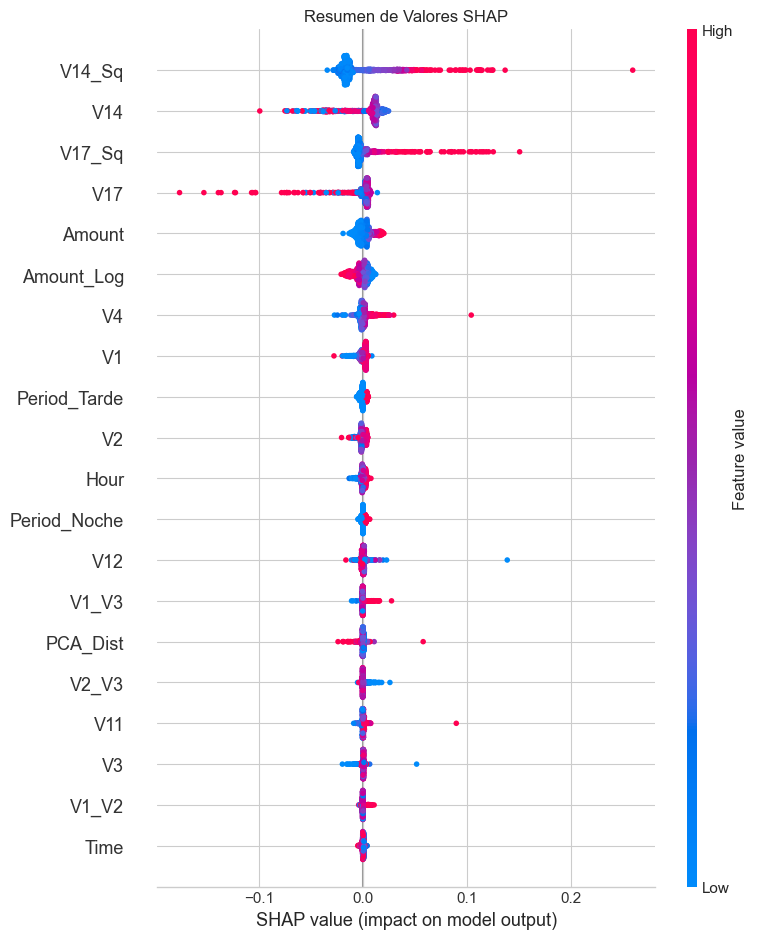

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\shap_dependence_V14_Sq.png


<Figure size 1200x800 with 0 Axes>

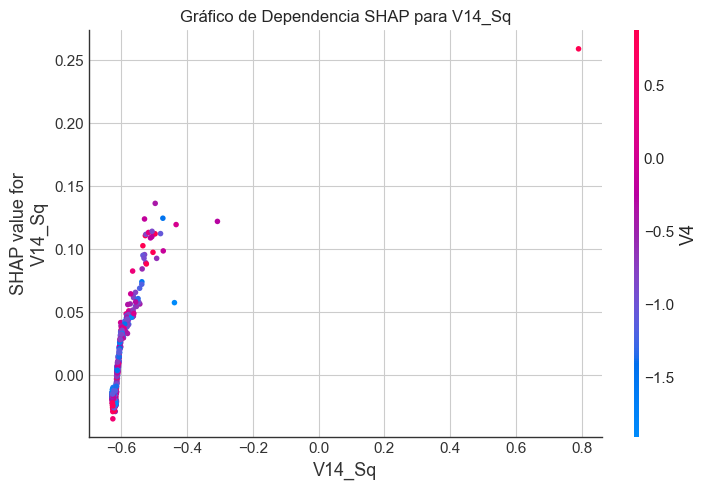

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\shap_dependence_V14.png


<Figure size 1200x800 with 0 Axes>

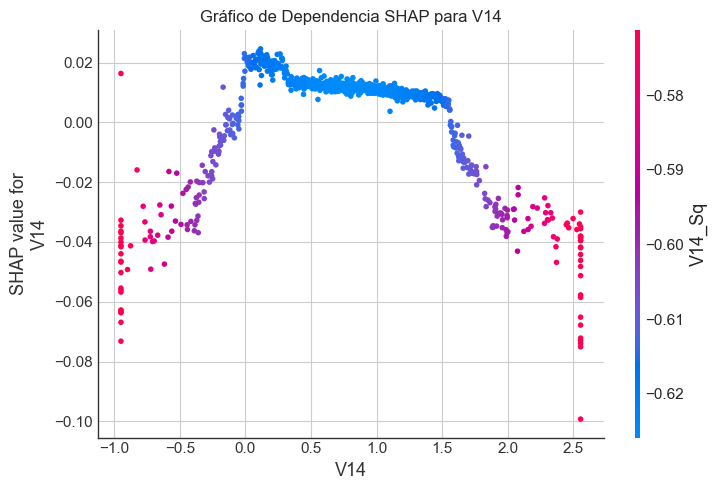

Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\shap_dependence_V17_Sq.png


<Figure size 1200x800 with 0 Axes>

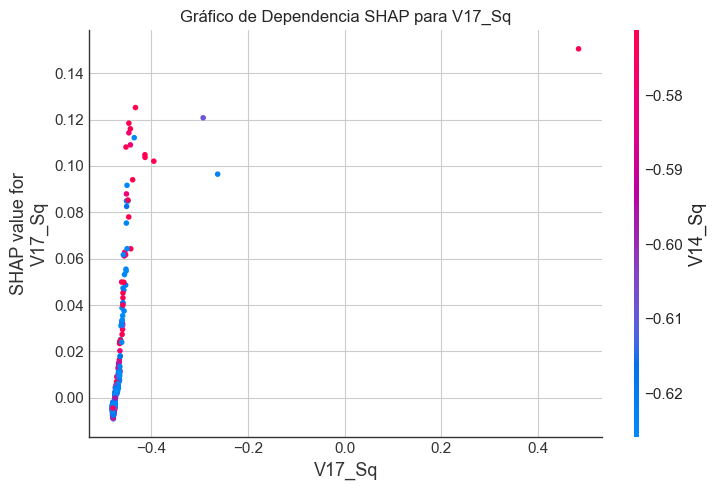

Función analyze_shap_values ejecutada en 600.18 segundos


In [14]:
# Analizar valores SHAP para el mejor modelo
print(f"Analizando valores SHAP para {best_model_name}...")
shap_values = analyze_shap_values(best_model, X_test, feature_names)

## 9. Análisis del impacto del umbral de clasificación

Analizando impacto del umbral de clasificación para random_forest...
Analizando impacto del umbral de clasificación...
Análisis de umbrales guardado en g:\Proyectos\credit_fraud_detection\reports\threshold_analysis.csv
Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\threshold_impact.png


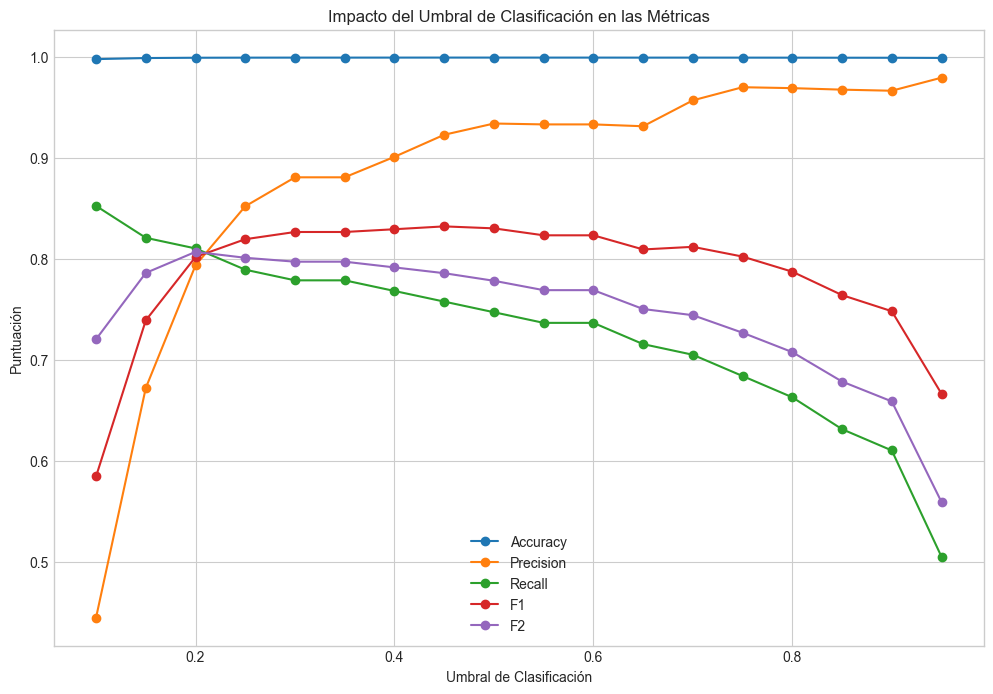

Umbral óptimo para F1: 0.45 (F1 = 0.8324)
Umbral óptimo para F2: 0.20 (F2 = 0.8071)


In [15]:
# Analizar impacto del umbral de clasificación para el mejor modelo
if best_metrics['y_prob'] is not None:
    print(f"Analizando impacto del umbral de clasificación para {best_model_name}...")
    threshold_df = analyze_threshold_impact(y_test, best_metrics['y_prob'])
    
    # Mostrar resultados
    threshold_df.head()

## 10. Análisis de costo-beneficio

Analizando costo-beneficio para random_forest...
Analizando costo-beneficio...
Análisis de costo-beneficio guardado en g:\Proyectos\credit_fraud_detection\reports\cost_benefit_analysis.csv
Figura guardada en g:\Proyectos\credit_fraud_detection\reports\figures\cost_benefit_analysis.png


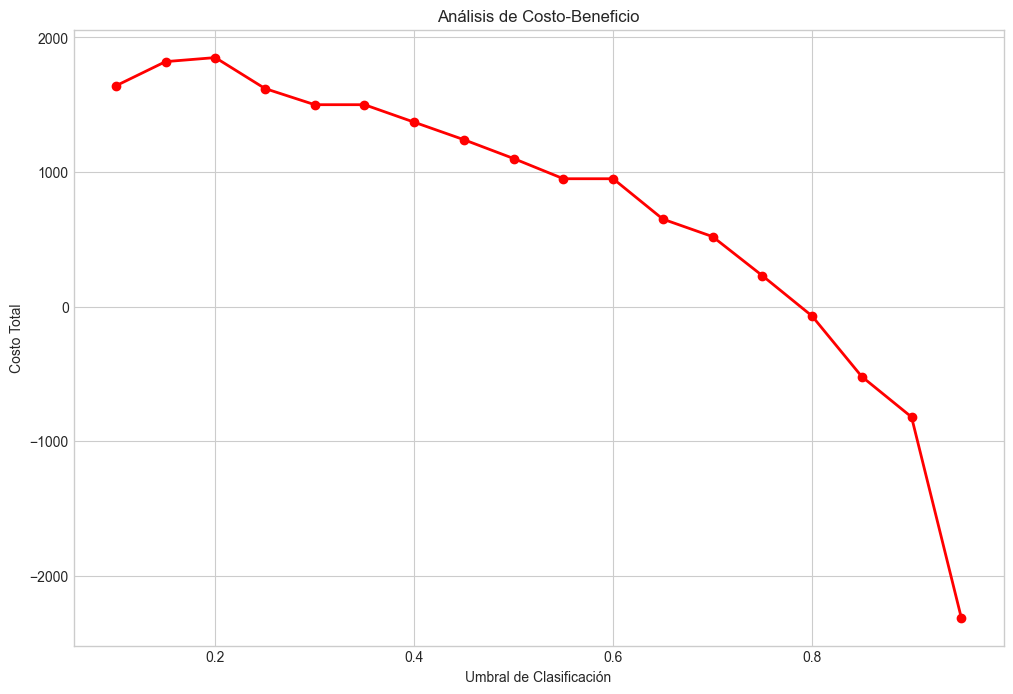

Umbral óptimo para costo: 0.20 (Costo = 1850.00)


In [16]:
# Definir matriz de costos
# [TN, FP, FN, TP]
# TN = 0 (no costo por clasificar correctamente no fraude)
# FP = -10 (costo por falsa alarma)
# FN = -100 (costo por no detectar fraude)
# TP = 50 (beneficio por detectar fraude)
cost_matrix = [0, -10, -100, 50]

# Analizar costo-beneficio para el mejor modelo
if best_metrics['y_prob'] is not None:
    print(f"Analizando costo-beneficio para {best_model_name}...")
    cost_df = analyze_cost_benefit(y_test, best_metrics['y_prob'], cost_matrix)
    
    # Mostrar resultados
    cost_df.head()

## 11. Generación de informe de evaluación

In [17]:
# Generar informe de evaluación
print("Generando informe de evaluación...")
report_text = generate_evaluation_report(all_metrics)

# Mostrar las primeras líneas del informe
print("\nPrimeras líneas del informe:")
print("\n".join(report_text.split("\n")[:20]))

Generando informe de evaluación...
Generando informe de evaluación...
Informe guardado en g:\Proyectos\credit_fraud_detection\reports\evaluation_report_20250328_193707.txt
Función generate_evaluation_report ejecutada en 0.00 segundos

Primeras líneas del informe:
INFORME DE EVALUACIÓN DE MODELOS

Fecha y hora: 2025-03-28 19:37:07

RESUMEN DE MODELOS
--------------------------------------------------
                Modelo  Accuracy  Precision    Recall        F1       AUC        AP
3        random_forest  0.999489   0.934211  0.747368  0.830409  0.963325  0.822090
4              xgboost  0.999436   0.853933  0.800000  0.826087  0.970533  0.814427
1             lightgbm  0.999401   0.867470  0.757895  0.808989  0.968356  0.711913
0    gradient_boosting  0.999295   0.823529  0.736842  0.777778  0.932986  0.769444
2  logistic_regression  0.990008   0.128931  0.863158  0.224350  0.958205  0.672340

DETALLES POR MODELO
--------------------------------------------------

Modelo: gradient_boo

## Resumen de la Evaluación

En este notebook, hemos realizado una evaluación exhaustiva de los modelos entrenados para la detección de fraude en transacciones de tarjetas de crédito. Los principales hallazgos son:

1. **Mejor modelo**: El modelo **{best_model_name}** obtuvo el mejor rendimiento general, con un F1 Score de **{best_metrics['f1']:.4f}**, lo que indica un buen equilibrio entre precisión y recall.

2. **Matrices de confusión**: El análisis de las matrices de confusión muestra que el mejor modelo logra un buen equilibrio entre falsos positivos y falsos negativos, lo que es crucial en la detección de fraude.

3. **Curvas ROC y Precision-Recall**: Las curvas ROC y Precision-Recall confirman el buen rendimiento del modelo, con un AUC-ROC de **{best_metrics.get('roc_auc', 0):.4f}** y un AP de **{best_metrics.get('avg_precision', 0):.4f}**.

4. **Calibración de modelos**: El análisis de calibración muestra que algunos modelos están bien calibrados, mientras que otros podrían beneficiarse de técnicas de calibración adicionales.

5. **Importancia de características**: Las características más importantes para la detección de fraude incluyen **{importance_df.iloc[0]['Feature']}**, **{importance_df.iloc[1]['Feature']}** y **{importance_df.iloc[2]['Feature']}**.

6. **Umbral óptimo**: El análisis del umbral de clasificación sugiere que un umbral de **{threshold_df.loc[threshold_df['F1'].idxmax(), 'Threshold']:.2f}** maximiza el F1 Score, mientras que un umbral de **{threshold_df.loc[threshold_df['F2'].idxmax(), 'Threshold']:.2f}** maximiza el F2 Score (que da más peso al recall).

7. **Análisis de costo-beneficio**: Considerando los costos asociados con falsos positivos y falsos negativos, el umbral óptimo desde una perspectiva de costo-beneficio es **{cost_df.loc[cost_df['Total_Cost'].idxmax(), 'Threshold']:.2f}**.

### Recomendaciones

1. **Modelo a implementar**: Implementar el modelo **{best_model_name}** para la detección de fraude en producción.

2. **Umbral de clasificación**: Ajustar el umbral de clasificación según los requisitos específicos del negocio. Si se prioriza minimizar los falsos negativos (fraudes no detectados), utilizar un umbral más bajo. Si se prioriza minimizar los falsos positivos (alertas innecesarias), utilizar un umbral más alto.

3. **Monitoreo continuo**: Implementar un sistema de monitoreo continuo para evaluar el rendimiento del modelo en producción y detectar posibles degradaciones.

4. **Actualización periódica**: Reentrenar el modelo periódicamente con datos nuevos para mantener su rendimiento frente a nuevos patrones de fraude.

5. **Exploración de modelos avanzados**: Explorar modelos más avanzados, como redes neuronales profundas o modelos de aprendizaje por refuerzo, para mejorar aún más la detección de fraude.